# Data Acquisition

In [1]:
import os
import shutil

import pandas as pd
import numpy as np
import torch

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [2]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"
GDRIVE_DATASET_DIR = f"/content/drive/My Drive/{GDRIVE_DATA_DIR}features/spectogram/"

## Mount Google Drive

In [3]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


In [4]:
import os
# Check if the directory exists and create it if not
if not os.path.exists(GDRIVE_DATASET_DIR):
    os.makedirs(GDRIVE_DATASET_DIR)
    print(f"Directory '{GDRIVE_DATASET_DIR}' created.")
else:
    print(f"Directory '{GDRIVE_DATASET_DIR}' already exists.")


Directory '/content/drive/My Drive/23-24_CE903-SU_team06/dataset/features/spectogram/' created.


## Visual Validation of Overlapping Frames

In [5]:
def visualize_overlapping_frames(title, framed_df, visual_set):
  for i, v in visual_set.items():
    #print( framed_df[framed_df["key"] == v]["max_amp"].idxmax() )
    findex = framed_df[framed_df["key"] == v]["max_amp"].idxmax() - 1
    hop_length = (framed_df.loc[findex]["end"] - framed_df.loc[findex]["start"]) // 2
    print('Hop Length:', hop_length)
    frame1 = framed_df.loc[findex]["amp"]
    frame2 = framed_df.loc[findex+1]["amp"]
    frame3 = framed_df.loc[findex+2]["amp"]
    # Plot the overlapping frames
    plt.figure(figsize=(12, 6))

    # Plot first frame
    plt.plot(np.arange(len(frame1)), frame1, label='Frame 1')

    # Plot second frame
    plt.plot(np.arange(hop_length, hop_length + len(frame2)), frame2 + 1, label='Frame 2')

    # Plot third frame
    plt.plot(np.arange(2 * hop_length, 2 * hop_length + len(frame3)), frame3 + 2, label='Frame 3')

    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title(f'{title} {i} {v}')
    plt.legend()
    plt.show()

def apply_framing(audio_df):
  def create_overlapping_frames(key, amp, label, sf, frame_size, hop_length):
    # Calculate the total number of frames
    if len(amp) == len(label):
      total_frames = 1 + int((len(amp) - frame_size) / hop_length)
      dic = {"key":[], "sf":[], "start":[], "end":[], "max_amp":[], "frame_index":[], "amp":[], "label":[]}

      # Create overlapping frames
      for i in range(total_frames):
        dic["key"].append(key)
        dic["sf"].append(sf)
        dic["start"].append(i * hop_length)
        dic["end"].append(i * hop_length + frame_size)
        dic["max_amp"].append(np.max(amp[i * hop_length: i * hop_length + frame_size]))
        dic["frame_index"].append(i)
        dic["amp"].append(amp[i * hop_length: i * hop_length + frame_size])
        frames_label_raw = label[i * hop_length: i * hop_length + frame_size]

        f_label = 0
        if np.sum(frames_label_raw==1) > (len(frames_label_raw) / 2):
          f_label = 1
        dic["label"].append(f_label)

      return dic
    else:
      print('Error: non matching amp and labels', key, len(amp), len(label))

  def create_and_label_frames(audio_df):
    return create_overlapping_frames(audio_df.name, audio_df["amp"], audio_df["label"],audio_df["sf"],frame_size, hop_length)

  all_frames = {}
  for frame_size in [256, 512, 1024, 2048]:
    hop_length = frame_size // 2

    frame_df = pd.DataFrame()
    #xx = audio_df.head(1).apply(create_and_label_frames, axis=1)
    xx = audio_df.apply(create_and_label_frames, axis=1)
    for x in xx:
      if len(frame_df) > 0:
        frame_df = pd.concat([frame_df, pd.DataFrame(x)], ignore_index=True)
      else:
        frame_df = pd.DataFrame(x)

    all_frames[frame_size] = frame_df
    print(f'Frame size {frame_size}, hop_length {hop_length}, count {len(frame_df)}')
  return all_frames

### Test to Validate Reading the Saved File

In [6]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [7]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save

,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
key,,,,,,,,
a24e3cbe-eda1-40b9-8f9d-57c939ef3663,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...","[-6.8540386e-12, -6.674442e-12, 4.356682e-12, ...",16000,22050,[27840],[38367],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28b68991-11d8-48dd-b0ce-ab7bb44f0383,"[1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[157440],[216972],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0b2f75d7-f116-4f35-ae4c-f2018eab2794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[155520],[214326],"[[1.651429, 1.891429], [2.022857, 2.331429], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
d2ce5b46-e4ca-4a35-938a-d18309ec8537,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[160367],[221005],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
eade4e05-0fe3-4736-8a9c-35467d078113,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[158400],[218295],"[[1.13332, 1.522777], [2.710622, 3.119552], [3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
e6448323-4be3-4fac-ba98-33aee0de0817,"[-1.4024037e-12, 1.8094825e-12, -1.8148147e-12...","[-2.0483938e-12, -1.3684832e-12, 1.4425688e-12...",16000,22050,[149760],[206388],"[[2.349541, 2.766729], [4.275026, 4.606638], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
42d1cba8-f6a3-45f3-971b-03e212ce4142,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[157440],[216972],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6147e276-9553-46cf-970c-a5c43309a5fc,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[25920],[35721],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Test to Create Frames and Labels from the Saved File Data

In [8]:
all_frames_from_save = apply_framing(audio_df=df_from_save)

Frame size 256, hop_length 128, count 333215
Frame size 512, hop_length 256, count 166399
Frame size 1024, hop_length 512, count 82957
Frame size 2048, hop_length 1024, count 41222


In [9]:
df_frame_from_save = all_frames_from_save[2048]
df_frame_from_save

,key,sf,start,end,max_amp,frame_index,amp,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,2048,8.836885e-05,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,3072,6.644696e-05,1,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,2048,4096,9.907748e-16,2,"[-1.5186867e-16, -6.784829e-17, 7.3962843e-16,...",0
3,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,3072,5120,0.000000e+00,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,4096,6144,9.463550e-09,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
41217,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,66560,68608,3.707021e-05,65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
41218,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,67584,69632,3.707021e-05,66,"[2.8157958e-12, -4.1274818e-13, 1.3529431e-13,...",0
41219,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,68608,70656,3.533897e-05,67,"[-7.5449933e-13, -1.1767322e-12, 6.144354e-14,...",0
41220,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,69632,71680,3.533897e-05,68,"[1.4073834e-07, -1.5136347e-07, 1.5978313e-07,...",0


In [10]:
visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
visual_set

{'1st': 'a24e3cbe-eda1-40b9-8f9d-57c939ef3663',
 'Last': 'fd849b72-f4bf-4852-9bc2-fd9becc9571e'}

Hop Length: 1024


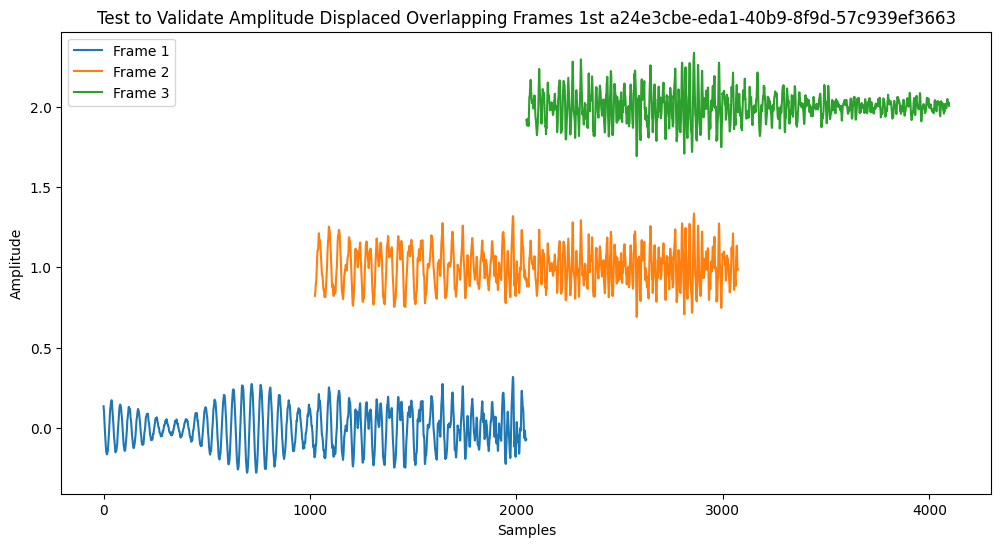

Hop Length: 1024


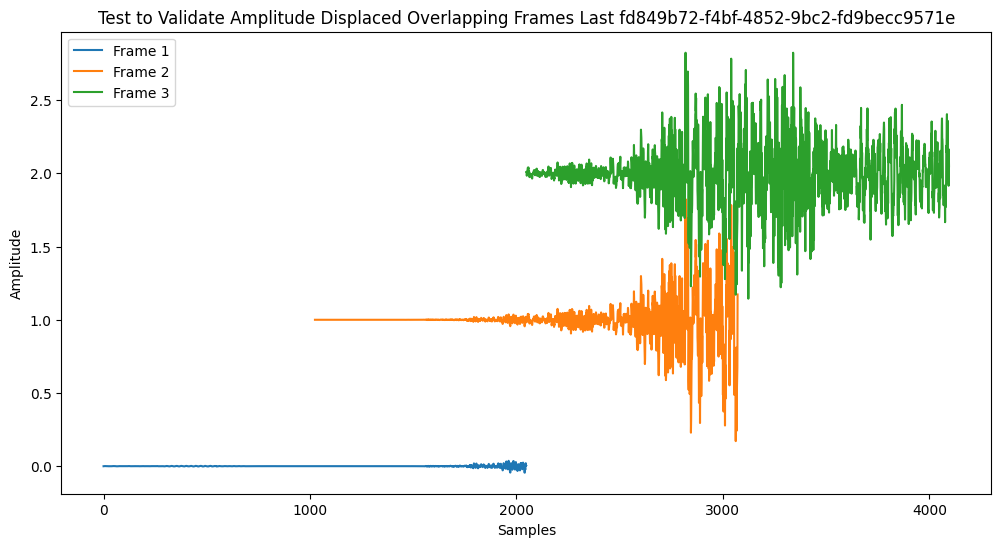

In [11]:
visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

# Feature Extraction Code

In [12]:
all_frames_from_save[2048]

,key,sf,start,end,max_amp,frame_index,amp,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,2048,8.836885e-05,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,3072,6.644696e-05,1,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,2048,4096,9.907748e-16,2,"[-1.5186867e-16, -6.784829e-17, 7.3962843e-16,...",0
3,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,3072,5120,0.000000e+00,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,4096,6144,9.463550e-09,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
41217,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,66560,68608,3.707021e-05,65,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
41218,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,67584,69632,3.707021e-05,66,"[2.8157958e-12, -4.1274818e-13, 1.3529431e-13,...",0
41219,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,68608,70656,3.533897e-05,67,"[-7.5449933e-13, -1.1767322e-12, 6.144354e-14,...",0
41220,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,69632,71680,3.533897e-05,68,"[1.4073834e-07, -1.5136347e-07, 1.5978313e-07,...",0


# Your Feature Extraction Code


In [13]:
class FeatureExtractionSpectrogram:
  def stft(self, df):
    """Read audio data and apply short_time_fourier_transform

      Parameters:
      df (pd.DataFrame): Pandas DataFrame

      Return df
    """
    ft = []
    ft_shape = []
    for index, row in df.iterrows():
      n_fft = min(2048, len(row["amp"]))
      stft = librosa.amplitude_to_db(np.abs( librosa.stft(row["amp"], n_fft=n_fft) ), ref=np.max)
      ft.append( stft )
      ft_shape.append( stft.shape )

    df["stft"] = ft
    df["stft_shape"] = ft_shape

    return df

  def stft_optimized(self, row):
    """Read audio data and apply short_time_fourier_transform in shorter period of time

      Parameters:
      df.row (pd.DataFrame): Pandas DataFrame

      Return df.row
    """
    #stft = librosa.amplitude_to_db(np.abs( librosa.stft(row["amp"], n_fft=128, hop_length=64, win_length=64) ), ref=np.max)
    stft = librosa.amplitude_to_db(np.abs( librosa.stft(row["amp"], n_fft=self.n_fft, hop_length=self.hop_length, win_length=self.win_length) ), ref=np.max)
    return stft

  def set_sftt_params(self, n_fft, hop_length, win_length):
    self.hop_length = hop_length
    self.n_fft = n_fft
    self.win_length = win_length
    print(f'using n_fft:{self.n_fft}, hop length:{self.hop_length}, win_length:{self.win_length}')

  def plot_spectrogram(self, file_name, S_DB, sr, hop_length=512):
    plt.figure(figsize=(10, 4))
    #librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
    #linear is not used bcos it results in max y-axis value of upto 8000 instead of 4096
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram {file_name} at {sr/1000}Khz, Hop {hop_length}')
    plt.tight_layout()
    plt.show()

  def save_spectogram_data(self, df, file_name, dir='', temporary=True):
    """Save data to npy format for later reuse

      Parameters:
      df.row (pd.DataFrame): Pandas DataFrame

      Return none
    """
    # Save spectrograms and labels as NumPy arrays
    if temporary:
        dir = '/content/'

    np.save(f'{dir}{file_name}.npy', df)
    # Extract column headings
    np.save(f'{dir}{file_name}_columns.npy', df.columns.to_numpy())

  def load_spectogram_data(self, file_name, dir='', temporary=True):
    """Load data from npy format

      Parameters:
      df.row (pd.DataFrame): Pandas DataFrame

      Return df
    """
    if temporary:
        dir = '/content/'
    # Save spectrograms and labels as NumPy arrays
    data = np.load(f'{dir}{file_name}.npy', allow_pickle=True)
    col = np.load(f'{dir}{file_name}_columns.npy',allow_pickle=True)
    return pd.DataFrame(data,columns=col)

  def get_spectogram_dataset(self, frames_dic={}, frame_size=1024, limit=0, n_fft=1024, hop_length=64, win_length=1024, use_gpu=True):
    """Extract Spectogram dataset from all_frames_dic its optimized to be faster about 1m 42s for 1028

      Parameters:
      frames_dic (dict): Dictionary with key = frame_size and value = df
      frame_size (int): Frame sizes to extract spectogram
      limit (int): Limit to stop extraction after X records, useful for debugging

      Return dict
    """
    dfc = None
    if frame_size in frames_dic:
      print('starting:', frame_size )
      self.set_sftt_params(n_fft=n_fft, hop_length=hop_length, win_length=win_length)
      if limit > 0:
        dfc = frames_dic[frame_size].copy().head(limit)
      else:
        dfc = frames_dic[frame_size].copy()

      if use_gpu and self.has_gpu():
        dfc['stft'] = self.use_gpu_for_stft(dfc["amp"])
      else:
        if use_gpu:
          print('Failed to find GPU')
        dfc['stft'] = dfc.apply(self.stft_optimized, axis=1)

    else:
      print('frame size not found:', frame_size )

    return dfc

  def has_gpu(self):
    """Test to determine if GPU is avialable

    Return torch.device
    """
    has_gpu = False
    device = 'cpu'
    if torch.cuda.is_available():
      device = 'cuda'
      has_gpu = True
    print(f'Using device: {device}')
    return device

  def use_gpu_for_stft(self, amps):
    """
    Computes the Short-Time Fourier Transform (STFT) of an audio signal on the GPU

    Parameters:
    self (object): Reference to the class instance (likely for accessing device).
    amps (torch.Tensor): The audio signal as a n-D tensor (where n is the number of rows)

    Returns:
        list: A list containing the magnitude spectrograms (in dB) of the audio samples after performing STFT on GPU.
    """
    # Convert NP array to have float dtype
    amps_np = np.stack(amps.values)

    # Convert the NumPy array to a tensor
    amps_tensor = torch.tensor(amps_np)

    # Move tensor to GPU
    amps_tensor = amps_tensor.cuda()

    window = torch.hann_window(self.n_fft).cuda()  # Window function

    # Perform STFT
    stft_output = torch.stft(
        amps_tensor,
        n_fft=self.n_fft,
        hop_length=self.hop_length,
        win_length=self.win_length,
        window=window,
        return_complex=True
    )

    # Compute the magnitude of the STFT
    #stft_db = torch.abs(stft_output)
    magnitude = torch.abs(stft_output)

    # log to base e, natural log
    #stft_db = torch.log(stft_db)

    # log to base 10
    #stft_db = torch.log(stft_db) / torch.log(torch.tensor(2.0))

    # Convert the magnitude to decibels
    stft_db = self.amplitude_to_db_gpu(magnitude, ref=torch.max(magnitude))

    return list(stft_db.cpu().numpy())

  def amplitude_to_db_gpu(self, tensor, ref=1.0, amin=1e-20):
    """
    Converts an amplitude spectrogram to decibel (dB) scale in PyTorch.

    Parameters:
    spectrogram (torch.Tensor): The amplitude spectrogram with shape (..., freq, time).
    ref (float, optional): Reference value for dB conversion. Defaults to 1.0.

    Returns:
        torch.Tensor: The spectrogram converted to dB scale with the same shape as input.
    """
    # Ensure the spectrogram is non-negative (avoiding issues with log)
    spectrogram = torch.clamp(tensor, min=amin)  # Small value to prevent log(0)

    # Convert to power spectrogram (square the elements)
    power_spectrogram = spectrogram**2

    # Calculate dB relative to reference
    S_db = 20 * torch.log10(power_spectrogram / ref)

    return S_db

fe = FeatureExtractionSpectrogram()

# Sub-framing, Formulas & All

## N_FFT
The number of points used in the FFT (Fast Fourier Transform) computation. It determines the size of the FFT window

The number of frequency bins in the output (output bin size - obs) = (1 + n_fft) // 2  
Thus, n_fft = (obs * 2) - 1

e.g To get 64 frequency bins in the output:
- 64 = (1 + n_fft) // 2
- n_fft = (64 * 2) - 1

## Hop_length
- Distance between centers of 2 consecutive frames.
- For the purpose of this study we shall adopt this as percentages of the frame length i.e 50%, 25% etc

- No. of sub-frames = frame size / ((sub-frame size + 1) * hop_percent / 100)
- Thus, 50% hop length of 1024 frame size and 128 sub-frame size will give us 16 frames

## Win_length
- Purpose to smoothen and reduce spectral leakage in the spectrum

- The size of the window function applied to each frame before computing the FFT. It defaults to n_fft

- If less than n_fft, the FFT will zero-pad the windowed signal, potentially affecting the spectral leakage and smoothing of the resulting spectrum.

## Reference
https://www.mathworks.com/help/dsp/ref/dsp.stft.html

In [14]:
frame_size = 1024

obs = 64  #The number of frequency bins in the output (output bin size - obs)

n_fft = (obs * 2) - 1   #sub-frame size
win_length = n_fft  #apply windowing function to the entire length of the frame

hop_percent = 50
hop_length = (n_fft + 1) * hop_percent // 100

df_1024 = fe.get_spectogram_dataset(
    frame_size=frame_size,
    frames_dic=all_frames_from_save,
    limit=0,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    use_gpu=False
)

# save dataset in cache / temp storage, it helps to free up memory when fully implemented
fe.save_spectogram_data(df=df_1024, file_name=frame_size, dir='', temporary=True)

# save dataset to Gdrive, not used due to delay in push and pulling to git server
#fe.save_spectogram_data(df=df_1024, file_name=frame_size, dir=GDRIVE_DATASET_DIR, temporary=False)

df_1024.info()

starting: 1024
using n_fft:127, hop length:64, win_length:127
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82957 entries, 0 to 82956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          82957 non-null  object 
 1   sf           82957 non-null  int64  
 2   start        82957 non-null  int64  
 3   end          82957 non-null  int64  
 4   max_amp      82957 non-null  float32
 5   frame_index  82957 non-null  int64  
 6   amp          82957 non-null  object 
 7   label        82957 non-null  int64  
 8   stft         82957 non-null  object 
dtypes: float32(1), int64(5), object(3)
memory usage: 5.4+ MB


# Test Plot for Visual Validation

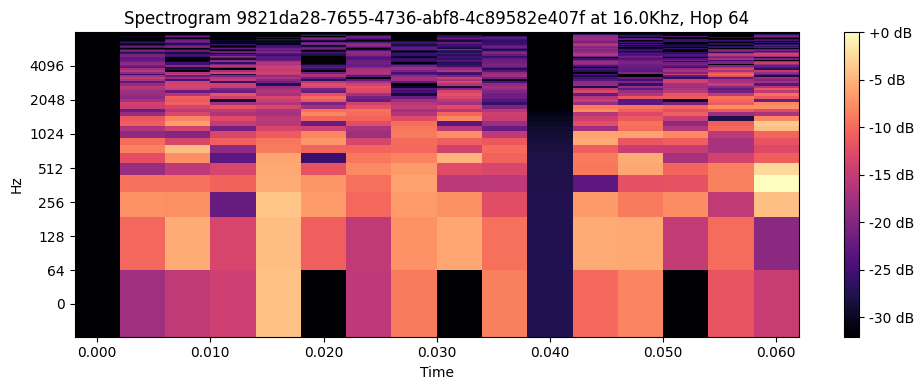

shape of stft (64, 16)
shape of the frame (1024,)


,key,sf,start,end,max_amp,frame_index,amp,label,stft
311,9821da28-7655-4736-abf8-4c89582e407f,16000,0,1024,0.000260,0,"[2.4100282e-19, 4.552187e-20, -4.743169e-19, -...",0,"[[-51.059193, -51.059193, -51.059193, -51.0591..."
312,9821da28-7655-4736-abf8-4c89582e407f,16000,512,1536,0.000527,1,"[-2.2809586e-13, 2.4235616e-13, -2.5261767e-13...",0,"[[-58.507927, -58.507927, -58.507927, -58.5079..."
313,9821da28-7655-4736-abf8-4c89582e407f,16000,1024,2048,0.000737,2,"[5.5891054e-05, 0.00021803637, 0.00024021938, ...",0,"[[-18.885334, -32.74474, -24.695766, -35.10622..."
314,9821da28-7655-4736-abf8-4c89582e407f,16000,1536,2560,0.000922,3,"[1.42881745e-05, -3.4426583e-05, 2.6231002e-05...",0,"[[-11.560276, -21.754932, -18.039566, -18.9115..."
315,9821da28-7655-4736-abf8-4c89582e407f,16000,2048,3072,0.000922,4,"[0.0008490162, 0.0005570182, 0.00032274745, 0....",0,"[[-28.875217, -18.529537, -17.38078, -24.56908..."
...,...,...,...,...,...,...,...,...,...
606,9821da28-7655-4736-abf8-4c89582e407f,16000,151040,152064,0.000035,295,"[-7.700891e-08, -1.1894869e-08, 8.98313e-08, -...",0,"[[-6.08123, -14.986046, -11.597763, -18.588615..."
607,9821da28-7655-4736-abf8-4c89582e407f,16000,151552,152576,0.000057,296,"[2.8354348e-06, 2.6322938e-05, 2.7386598e-06, ...",0,"[[-19.990303, -18.756165, -19.800034, -8.37455..."
608,9821da28-7655-4736-abf8-4c89582e407f,16000,152064,153088,0.000057,297,"[-1.4644161e-06, 2.2830393e-06, -5.1760608e-06...",0,"[[-4.9242554, -31.57219, -7.556259, -15.962433..."
609,9821da28-7655-4736-abf8-4c89582e407f,16000,152576,153600,0.000062,298,"[-7.7346846e-07, 4.2284967e-09, 6.061488e-07, ...",0,"[[-27.41166, -6.1541214, -8.564682, -11.30648,..."


In [ ]:
key = 411
fe.plot_spectrogram( file_name=df_1024['key'][key], S_DB=np.array(df_1024['stft'][key]), sr=df_1024['sf'][key], hop_length=64 )
print('shape of stft', df_1024['stft'][key].shape )
print('shape of the frame', df_1024['amp'][key].shape )

df_1024[ df_1024['key'] == '9821da28-7655-4736-abf8-4c89582e407f' ]

# Transfer Code to Python Module - Feature_extraction.py

In [ ]:
%load_ext autoreload
%autoreload 2


GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/components/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['__init__.py', 'data_ingestion.py', 'data_transformation.py', 'model_evaluation.py', 'model_pusher.py', 'model_trainer.py', 'feature_extraction.py', '.ipynb_checkpoints']


In [ ]:
from feature_extraction import Spectrogram
ffe = Spectrogram()
help(ffe)

Help on Spectrogram in module feature_extraction object:

class Spectrogram(builtins.object)
 |  Methods defined here:
 |  
 |  amplitude_to_db_gpu(self, tensor, ref=1.0, amin=1e-20)
 |      Converts an amplitude spectrogram to decibel (dB) scale in PyTorch.
 |      
 |      Parameters:
 |      spectrogram (torch.Tensor): The amplitude spectrogram with shape (..., freq, time).
 |      ref (float, optional): Reference value for dB conversion. Defaults to 1.0.
 |      
 |      Returns:
 |          torch.Tensor: The spectrogram converted to dB scale with the same shape as input.
 |  
 |  get_spectogram_dataset(self, frames_dic={}, frame_size=1024, limit=0, n_fft=1024, hop_length=64, win_length=1024, use_gpu=True)
 |      Extract Spectogram dataset from all_frames_dic its optimized to be faster about 1m 42s for 1028
 |      
 |      Parameters:
 |      frames_dic (dict): Dictionary with key = frame_size and value = df
 |      frame_size (int): Frame sizes to extract spectogram
 |      limi

# Test the Module

In [ ]:
all_frames_from_save[1024]

,key,sf,start,end,max_amp,frame_index,amp,label
0,6ba0829b-5840-480d-8db5-1ca39a95159a,16000,0,1024,0.0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,6ba0829b-5840-480d-8db5-1ca39a95159a,16000,512,1536,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,6ba0829b-5840-480d-8db5-1ca39a95159a,16000,1024,2048,0.0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,6ba0829b-5840-480d-8db5-1ca39a95159a,16000,1536,2560,0.0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,6ba0829b-5840-480d-8db5-1ca39a95159a,16000,2048,3072,0.0,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
82952,49cc8b94-838b-4b23-9fb1-8d9384520634,16000,153088,154112,0.0,299,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
82953,49cc8b94-838b-4b23-9fb1-8d9384520634,16000,153600,154624,0.0,300,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
82954,49cc8b94-838b-4b23-9fb1-8d9384520634,16000,154112,155136,0.0,301,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
82955,49cc8b94-838b-4b23-9fb1-8d9384520634,16000,154624,155648,0.0,302,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [ ]:
df_1024_test = ffe.get_spectogram_dataset(
    frame_size=frame_size,
    frames_dic=all_frames_from_save,
    limit=500,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    use_gpu=False
)
key = 411
ffe.plot_spectrogram( file_name=df_1024_test['key'][key], S_DB=np.array(df_1024_test['stft'][key]), sr=df_1024_test['sf'][key], hop_length=64 )
print('shape of stft', df_1024_test['stft'][key].shape )
print('shape of the frame', df_1024_test['amp'][key].shape )

df_1024_test[ df_1024_test['key'] == '9821da28-7655-4736-abf8-4c89582e407f' ]

starting: 1024
using n_fft:127, hop length:64, win_length:127


NameError: name 'all_frames_from_save' is not defined